# Pharaglow Analysis Notebook

In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import shutil
import timeit
from datetime import date
# image io and analysis
import json
import pims
from skimage.io import imsave
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
import pharaglow
from pharaglow import tracking, run, features, util, io, extract

# show logger messabes loally
import logging
logging.debug('pharaglow')

This notebook runs the pharaglow image analysis pipeline. It comprises three stages on analysis which can be done sequentially and are independent. Analyses can be interrupted at the end of each stage after saving the output dataframe. 

**1. Step -  Basic object detection**
    This step creates a "_features.json" file which contains a table of objects detected in each frame.
    Beyond finding the center of mass of an object, no further image analysis is done here.
    
**2. Step - Linking objects into trajectories**
    This results in individual files "_trajectory.json" for each tracked animal.
    
**3. Step - Analysing the details of object shapes**
    This step is doing the heavy lifting: It extracts centerlines, widths, contours and other object descriptors from the objects

All subsequent analyses steps add 'columns' to the data, and thus features is a subset of trajectories is a subset of results.

## 1. Setup

### Input parameters

In [2]:
parameterfile = "../AnalysisParameters_1x"
inPath = "/home/mscholz/Dropbox (Scholz Lab)/Shared/Data/MS0006_0_1000frames"
outPath = "/home/mscholz/Desktop/TestOutput_MS0006/"
lawnPath = None #"/opt/data/Lawns/"
movie = "MS0006_0_1000frames"
movieID = movie[-6:]
nWorkers = 5
nWorkers = 10
chunksize = 100
debug=False

parameterfile = "/opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/20210221_EB0068_parameters.txt"
inPath = "/opt/data/Elsa/1_Rawdata/20201217_solenoid_mutants/recording/EB0068c"
outPath = "/opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test"
lawnPath = None #"/opt/data/Lawns/"
movie = "EB0068c"
movieID = movie[:-1]
nWorkers = 10
chunksize = 100
debug=True

In [ ]:
# # Write the path of the directories where
# # > is the parameters file
# parameterfile = '/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/Linking/EB0068_parameters.txt'
# # > are the tiff files
# inPath = '/home/nif/Desktop/data/Elsa/1_Rawdata/20201217_solenoid_mutants/recording/EB0068c/'
# # > will be saved the pharaglow output files
# outPath = f'/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/broken_pharynx/'
# # > is the tiff file with the bacterial lawn (if no lawn: None)
# lawnPath = None #"/opt/data/Lawns/"

# # Set the names of the tiff files folder (movie) and the identification number (movieID) of the recording
# movie = "EB0068"
# movieID = movie # the ID should be AA1000
# # movieID = movie[-6:]

# # Set the number of processing cores used for the analysis
# nWorkers = 10
# chunksize = 100

# # Inactivate (False) or activate (True) the debug mode
# debug=False

#### Add a logger

In [3]:
today = date.today().strftime("%Y%m%d")
logger = io.log_setup('PharaGlow', 10, fname = os.path.join(outPath, f'{today}_{movieID}_pharaglow_log.txt'))

#### Check paths

In [4]:
npaths = {'parameter file': parameterfile,
          'inPath':inPath,
          'outPath': outPath}

for key, value in npaths.items():    
    if os.path.exists(value):
        print(f'{key}: {value}')
    else:
        print(f"Warning! The path for {key} doesnt exist: {value}")

parameter file: /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/20210221_EB0068_parameters.txt
inPath: /opt/data/Elsa/1_Rawdata/20201217_solenoid_mutants/recording/EB0068c
outPath: /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test


#### Creating new file names

In [5]:
fname = os.path.join(inPath,"*.tif*")
outfile = os.path.join(outPath, movieID+"_{}_{}.json")
imfile =  os.path.join(outPath, movieID+"_{}_{}.tiff")
logger.info(f"output file will be saved as {outfile}")
logger.info(f"output file will be saved as {imfile}")
saveparam = os.path.join(outPath, movieID+"_parameters")
logger.info(f"parameters file will be saved as {saveparam}")

INFO:PharaGlow:output file will be saved as /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/EB0068_{}_{}.json
INFO:PharaGlow:output file will be saved as /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/EB0068_{}_{}.tiff
INFO:PharaGlow:parameters file will be saved as /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/EB0068_parameters


### Load data

In [6]:
if debug:
    logger.debug('Select tiff files to analyze:')
    first_tiff = 6000 # tiff file identification number (minimum=1))
    last_tiff = 7200

    n = np.arange(first_tiff-1, last_tiff)  
    logger.debug(f'first tiff:{first_tiff}, n.min:{n.min()}')
    logger.debug(f'last tiff:{last_tiff}, n.max:{n.max()}')

DEBUG:PharaGlow:Select tiff files to analyze:
DEBUG:PharaGlow:first tiff:6000, n.min:5999
DEBUG:PharaGlow:last tiff:7200, n.max:7199


##### Load lawns if available

In [7]:
if lawnPath is not None and lawnPath != 'None':
    logger.info('Loading lawn file...')
    try:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.tiff')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
    except Exception:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.bmp')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
    logger.info("Lawnfile opened as 'lawn'")
else:
    lawnfile = None

##### Load images and analysis parameters

In [8]:
start = timeit.default_timer()
logger.info("Loading tiff files...")
rawframes = pims.open(fname)

if not debug:
    rawframes = rawframes
if debug:
    logger.debug(f"A subset of {len(n)} files will be analyzed")
    rawframes = rawframes[n]
logger.info("tiff files loaded as 'rawframes'")


logger.info(f"Loading parameters from {parameterfile}...")
with open(parameterfile) as f:
    param = json.load(f)
    f.close()
logger.info(f"parameters file loaded as 'param':{param}")

# Measure the wall time for running the current cell [s]
stop = timeit.default_timer()
logger.info(f"Loading time: {stop - start}s")  

INFO:PharaGlow:Loading tiff files...
DEBUG:PharaGlow:A subset of 1201 files will be analyzed
INFO:PharaGlow:tiff files loaded as 'rawframes'
INFO:PharaGlow:Loading parameters from /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/20210221_EB0068_parameters.txt...
INFO:PharaGlow:parameters file loaded as 'param':{'subtract': 0, 'smooth': 1, 'dilate': 1, 'tfactor': 0.65, 'thresholdWindow': 511, 'bgWindow': 111, 'length': 100, 'searchRange': 60, 'minimalDuration': 900, 'memory': 30, 'minSize': 600, 'maxSize': 3000, 'watershed': 100, 'widthStraight': 10, 'pad': 5, 'nPts': 200, 'linewidth': 2}
INFO:PharaGlow:Loading time: 0.5677223550155759s


#### Check if all the tiff files have been loaded as rawframes

In [9]:
nfiles = len([f for f in os.listdir(inPath) if '.tif' in f])
# tiff files
logger.info(f"Number of tiff files: {nfiles}")
# rawframes 
logger.info(f"Number of rawframes: {len(rawframes)}")

if nfiles != len(rawframes):
    if not debug:
        logger.warning("the number of tiff files doesn't match with the number of rawframes !")


INFO:PharaGlow:Number of tiff files: 27001
INFO:PharaGlow:Number of rawframes: 1201


### Improve lawn detection if neccessary

In [10]:
if lawnfile is not None:
    from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
    from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
    image = gaussian(lawn, 1, preserve_range = True)
    thresh = threshold_li(image, initial_guess = np.median)
    binary = image > thresh*0.5
    binary = remove_small_holes(binary, area_threshold=1500, connectivity=1, in_place=False)
    binary = remove_small_objects(binary, min_size=5000, connectivity=8, in_place=False)
    binLawn = binary
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(lawn)
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    plt.subplot(122)
    plt.imshow(binLawn)

## 2. Object detection

### Create binary masks

In [11]:
# param['bgWindow']=111
# logger.debug(f"parameter bgWindow changed to {param['bgWindow']}")

# param['thresholdWindow']=511
# logger.debug(f"parameters thresholdWindow changed to {param['thresholdWindow']}")

# param['tfactor'] = 0.65
# logger.debug(f"parameters tfactor changed to {param['tfactor']}")

# param['smooth']=1
# logger.debug(f"parameters smooth changed to {param['smooth']}")

# param['dilate']

In [12]:
start = timeit.default_timer()

# detecting objects
logger.info('Binarizing images...')

masks = tracking.calculateMask(rawframes,
                               minSize = param['minSize'],
                               bgWindow = param['bgWindow'],
                               thresholdWindow = param['thresholdWindow'],
                               smooth =  param['smooth'],
                               subtract =  param['subtract'],
                               dilate = param['dilate'],
                               tfactor=param['tfactor'])


stop = timeit.default_timer()
logger.info(f"binary masks created ({stop - start}s)")  

INFO:PharaGlow:Binarizing images...
INFO:PharaGlow:binary masks created (0.5131446829764172s)


### Make sure the thresholding worked otherwise change parameters

In [13]:
# Select a rawframe to visualize
t = 5400 

if t> (len(rawframes)-1):
    # Check if the selected rawframe is present otherwise t=0
    print(f"Warning ! Max {len(rawframes)} rawframes. {t} changed to 0")
    t=0

if debug:
    if first_tiff:
        print(f"rawframe {t} (or tiff {first_tiff+t}) to visualize")      
else:
    print(f"rawframe {t} to visualize ")

Warning ! Max 1201 rawframes. 5400 changed to 0
rawframe 0 (or tiff 6000) to visualize


##### Visualize the raw data

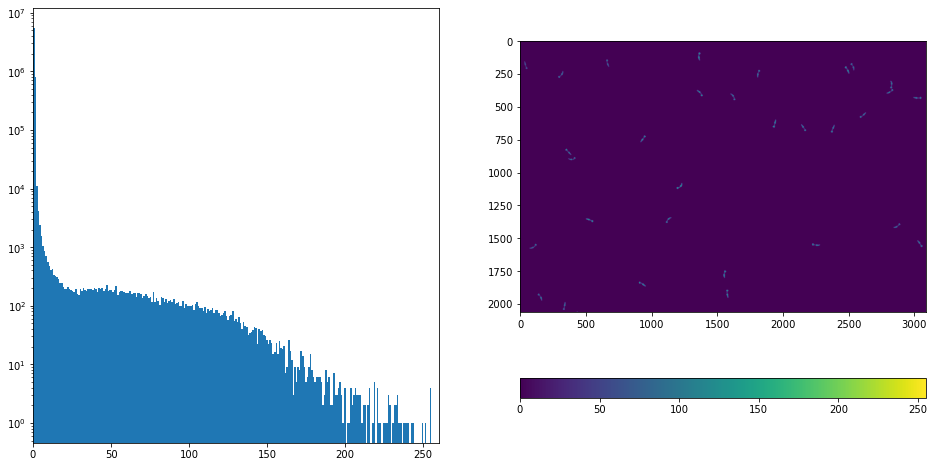

In [14]:
plt.figure(figsize=(16,8))

plt.subplot(121)
# Plot the histogram of the pixel intensity values of the rawframe
plt.hist(rawframes[t].ravel(), bins=256, log=True)
plt.xlim(0, 260) # xlim for 8 bits image

plt.subplot(122)
# Adjust the color limit for the rawframe for vizualisation only
# color = (0,150) # 0<=color<=255 for 8 bits image
color = None 
plt.imshow(rawframes[t],clim = color)
plt.colorbar(orientation='horizontal');

# plt.savefig(os.path.join(outPath,f'{today}_{movieID}_px_hist_{t}.pdf'))

##### Show the mask and detected objects

34 detected objects


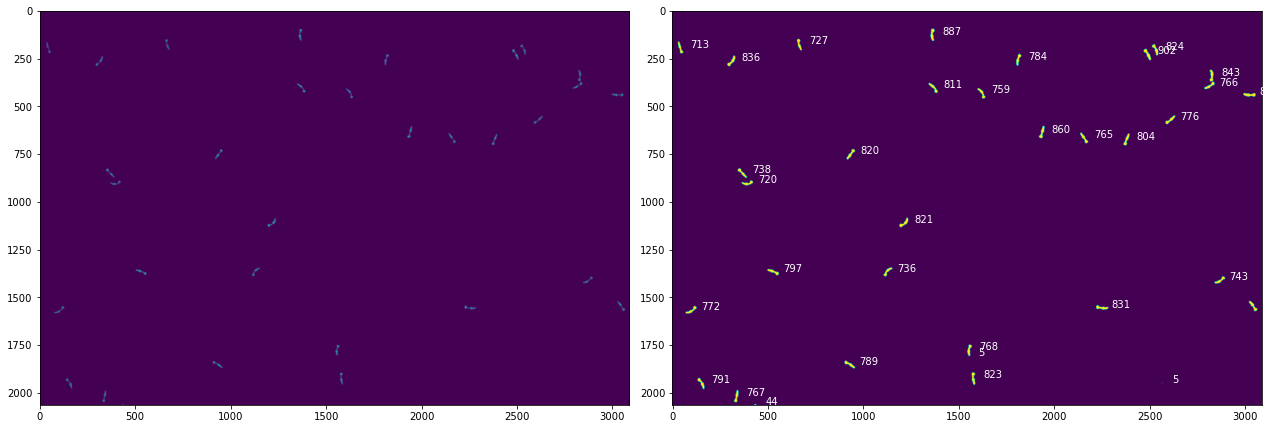

In [15]:
# %matplotlib qt

from skimage.measure import label, regionprops

plt.figure(figsize=(18,14))
plt.subplot(121)
# Show the rawframe
plt.imshow(rawframes[t],clim= color)#+lawn)
if lawnfile is not None:
    # Show the lawn
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    
plt.subplot(122)
# Show the masks and their size [px]
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
# print(np.min(masks[t]))
label_image, num = label(masks[t], background=0, connectivity = 1,return_num=True)
print(f"{num} detected objects")
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')

    
plt.tight_layout()

# if not debug:
#     plt.title(f"Rawframe and masks (#{num}) at t={t} ({movieID})",fontsize=24)
#     plt.savefig(os.path.join(outPath,f'{today}_{movieID}_masks_rawframe{t}.pdf'))
# if debug:
#     plt.title(f"Rawframe and masks (#{num}) at tiff {first_tiff+t} OR rawframe {t} ({movieID})", fontsize=24)
#     plt.savefig(os.path.join(outPath,f'{today}_{movieID}_masks_tiff{first_tiff+t}.pdf'))

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

This section will go through all frames and find worm-sized (as specified by the parameters) objects. It creates a pd.Dataframe containing these and a stack of images (numpy array) that contain a cropped area around each worm. Note: Each worm image will be length x length x 8bit. So with 30 worms per image you expect the image array to be 6Gb/10 minutes.

In [16]:
start = timeit.default_timer()

logger.info('Detecting features...')
logger.info(f'...with {nWorkers} workers')
objects, images = util.parallel_analysis((masks, rawframes), param, tracking.parallelWorker, framenumbers = None, nWorkers = nWorkers, output= None)
# create a link between image and dataframe
objects['im_idx'] = np.arange(len(objects))
stop = timeit.default_timer()
logger.info(f"features detected ({stop - start}s)") 

INFO:PharaGlow:Detecting features...
INFO:PharaGlow:...with 10 workers


Analyzing image 0 of 1201
Analyzing image 30 of 1201
Analyzing image 60 of 1201
Analyzing image 90 of 1201
Analyzing image 120 of 1201
Analyzing image 150 of 1201
Analyzing image 180 of 1201
Analyzing image 210 of 1201
Analyzing image 240 of 1201
Analyzing image 270 of 1201
Analyzing image 300 of 1201
Analyzing image 330 of 1201
Analyzing image 360 of 1201
Analyzing image 390 of 1201
Analyzing image 420 of 1201
Analyzing image 450 of 1201
Analyzing image 480 of 1201
Analyzing image 510 of 1201
Analyzing image 540 of 1201
Analyzing image 570 of 1201
Analyzing image 600 of 1201
Analyzing image 630 of 1201
Analyzing image 660 of 1201
Analyzing image 690 of 1201
Analyzing image 720 of 1201
Analyzing image 750 of 1201
Analyzing image 780 of 1201
Analyzing image 810 of 1201
Analyzing image 840 of 1201
Analyzing image 870 of 1201
Analyzing image 900 of 1201
Analyzing image 930 of 1201
Analyzing image 960 of 1201
Analyzing image 990 of 1201
Analyzing image 1020 of 1201
Analyzing image 1050 of 

/home/ebonnard/.local/lib/python3.7/site-packages/pharaglow/util.py:169: UserWarning: Image (53, 115) larger than pad size 100. Cropping
  warnings.warn(f'Image {sy, sx} larger than pad size {size}. Cropping')
/home/ebonnard/.local/lib/python3.7/site-packages/pharaglow/util.py:169: UserWarning: Image (53, 116) larger than pad size 100. Cropping
  warnings.warn(f'Image {sy, sx} larger than pad size {size}. Cropping')
/home/ebonnard/.local/lib/python3.7/site-packages/pharaglow/util.py:169: UserWarning: Image (51, 117) larger than pad size 100. Cropping
  warnings.warn(f'Image {sy, sx} larger than pad size {size}. Cropping')
/home/ebonnard/.local/lib/python3.7/site-packages/pharaglow/util.py:169: UserWarning: Image (51, 119) larger than pad size 100. Cropping
  warnings.warn(f'Image {sy, sx} larger than pad size {size}. Cropping')
/home/ebonnard/.local/lib/python3.7/site-packages/pharaglow/util.py:169: UserWarning: Image (50, 121) larger than pad size 100. Cropping
  warnings.warn(f'Image

INFO:PharaGlow:features detected (311.43340568896383s)


In [22]:
# Files monitoring
logger.info(f" Number of frames in features:{objects['frame'].nunique()}")
                                                       
if len(rawframes) != len(objects['frame'].unique()):
    logger.warning(f" Number of frames in features ({objects['frame'].nunique()}) and the number of rawframes ({len(rawframes)}) don't match !")

INFO:PharaGlow: Number of frames in features:1201


#### Visualize results of object detection

INFO:PharaGlow:features.area.min():663
INFO:PharaGlow:features.area.max():1702


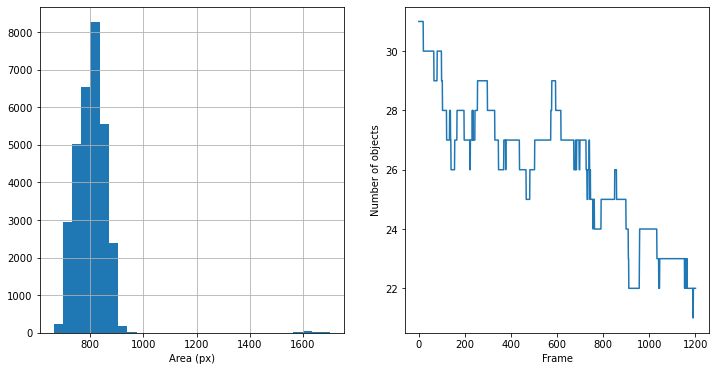

In [24]:
### Show the area of all objects
plt.figure(figsize=(12,6))
plt.subplot(121)
objects['area'].hist(bins = 30)
plt.xlabel('Area (px)')
plt.subplot(122)
objects['frame'].value_counts().sort_index().plot()
plt.ylabel('Number of objects')
plt.xlabel('Frame')
#features['frame'].hist(bins = len(rawframes))

logger.info(f"features.area.min():{objects.area.min()}") # region.area > params['minSize']
logger.info(f"features.area.max():{objects.area.max()}") # region.area < params['maxSize']

### Save features and images

In [27]:
start = timeit.default_timer()
# saving features
logger.info("Saving features...")
objects.info(memory_usage='deep')
objects.to_json(outfile.format('features', 'all'), orient='split')
stop = timeit.default_timer()
logger.info(f"features saved as {outfile.format('features', 'all')} ({stop - start}s)")

start = timeit.default_timer()
# saving images
imsave(imfile.format('images', 'all'), images)
stop = timeit.default_timer()
logger.info(f"images saved as {imfile.format('images', 'all')} ({stop - start}s)")

# saving parameter file
logger.info("Saving parameters...")
shutil.copyfile(parameterfile, saveparam, follow_symlinks=True)
logger.info(f"parameters saved as {parameterfile}")

INFO:PharaGlow:Saving features...
INFO:PharaGlow:features saved as /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/EB0068_features_all.json (0.06260135397315025s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31281 entries, 0 to 31280
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         31281 non-null  float64
 1   x         31281 non-null  float64
 2   slice_y0  31281 non-null  int64  
 3   slice_y1  31281 non-null  int64  
 4   slice_x0  31281 non-null  int64  
 5   slice_x1  31281 non-null  int64  
 6   frame     31281 non-null  int64  
 7   area      31281 non-null  int64  
 8   yw        31281 non-null  float64
 9   xw        31281 non-null  float64
 10  shapeY    31281 non-null  int64  
 11  shapeX    31281 non-null  int64  
 12  im_idx    31281 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 3.1 MB


INFO:PharaGlow:images saved as /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/EB0068_images_all.tiff (1.6723484880058095s)
INFO:PharaGlow:Saving parameters...
INFO:PharaGlow:parameters saved as /opt/data/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/20212004_new_pg_test/20210221_EB0068_parameters.txt


#### (Optional) Load features and images if continuing prior analysis

In [ ]:
%%time

if debug:
    # Load feature
    start = timeit.default_timer()
    logger.info("Loading features...")
    objects = io.load(outfile.format('features', 'all'), orient='split')
    images = pims.open(imfile.format('images', 'all'))
    stop = timeit.default_timer()
    logger.info(f"features loaded ({stop - start}s)")

## 3. Creating trajectories

### Link objects to trajectories using trackpy and interpolate short misses

In [ ]:
logger.info('Linking trajectories...')
logger.info(f"Parameter searchRange: {param['searchRange']} px")
logger.info(f"Parameter memory: {param['memory']} frames")

In [ ]:
#pred = tp.predict.NearestVelocityPredict()
#trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])
trajectories = tp.link_df(objects,param['searchRange'], memory = param['memory'])
logger.info(f"Number of trajectories after linking: {len(trajectories['particle'].unique())}")

In [ ]:
# Delete the variable features to save memory
del objects

#### Show the trajectories

In [ ]:
if debug:
    plt.figure(figsize=(8,8))
    tp.plot_traj(trajectories, colorby = 'particle', superimpose=1-masks[t],label=False);

In [ ]:
logger.info(f"Filtering out trajectories which last less than the minimal duration ({param['minimalDuration']} frames)...")
logger.info(f"Nb of trajectories before filtering: {trajectories['particle'].nunique()}")

trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
logger.info(f"Nb of trajectories after filtering: {trajectories['particle'].nunique()}")

#### Save individual trajectories & add the missing images to interpolated trajectories

Here we do multiple things: Add missing rows to the trajectory, create a separate image stack for each animal and save the trajectories.

#### Extract lawn info

In [ ]:
def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

In [ ]:
logger.info(f"Saving {trajectories['particle'].nunique()} trajectories to separate files...")

start = timeit.default_timer()

for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index].copy()
    ims = images[tmp['im_idx']]
    ims = np.array(ims, dtype = 'uint8')
    # generate an interpolated trajectory where all frames are accounted for
    traj_interp, ims_interp = tracking.interpolate_helper(rawframes, ims, tmp, param)
    # save the new single worm movie
    imsave(imfile.format('images', particle_index), np.array(ims_interp, dtype='uint8'))
    # save the trajectory
    traj_interp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')
    
stop = timeit.default_timer()
logger.info(f"trajectories saved as json files ({stop - start}s)") 



### check slow-down before continuing analysis

In [ ]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 1000
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            print('t0:', t0)
            try:
                if t0>dt:
                    print('pid:', pid)
                    time = np.linspace(0,2*dt/30., 2*dt)
                    #print('time:', len(time))
                    v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                    #print('v:', v)
                    #print('v.iloc:', v.iloc[t0-dt:t0+dt])
                    plt.plot(time, v.iloc[t0-dt:t0+dt], 'navy', alpha=0.1)
                    vcut.append(v.iloc[t0-dt:t0+dt].values)
                else:
                    print('trajectory is too short')
            except ValueError:
                print('t0-dt or t0+dt exceeds number of frames')
                continue
                    
    if len(vcut) >0:  
        plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
        plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
        plt.axvline(dt/30, color='k', linestyle='--')
        plt.ylabel(r"velocity ($\mu$m/s)");
        plt.xlabel("time (s)");
        plt.ylim(0,150)

## 3. Run the whole pharaglow feature extraction

In [ ]:
start = timeit.default_timer()
lawnfile = None
# save only minimal outputs - reduces save by approx factor 3
save_minimal = True
path = os.path.dirname(outfile)

# analyze all trajectories
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    
    if os.path.isfile(file) and f'{movieID}_trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  io.load(file, orient='split')
        # load images
        images = pims.open(imfile.format('images', particle_index))
        if len(traj.index)<1:
            print('Skipped', file)
            continue
      
        print('Analyzing trajectory:', fn)
        tmp,_ = util.parallel_analysis((images,), param,\
                          parallelWorker= run.parallel_pharaglow_run, framenumbers = traj['frame'], nWorkers = nWorkers, output= None)
       
       
        # remove some columns to make the result smaller
        if save_minimal:
            tmp = tmp.drop(['Mask', 'SkeletonX', 'SkeletonY', 'ParX', 'ParY', 
                            'Xstart', 'Xend', 'Centerline', 'dCl', 'Widths', 'Contour', 'Gradient', 
                            'Kymo', 'KymoGrad', 'Similarity', 'Xtmp'], axis = 1, errors = 'ignore')
        # add the basic tracker info - you can also keep these as separate files
        tmp = tmp.merge(traj, on='frame', how = 'outer')
        # run some stuff on the whole dataframe.
        run.pharynxorientation(tmp)
        # extract pumps
        tmp[['pumps']] = tmp.apply(\
        lambda row: pd.Series(features.extractPump(row['Straightened'])), axis=1)
        # get more exact entry location
        if lawnfile is not None:
            tmp['insideHead'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], binLawn)), axis=1)
            tmp['insideHeadIntensity'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], lawn)), axis=1)
        
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        
if save_minimal:
    logger.info('minimal information saved')
    
stop = timeit.default_timer()
logger.info(f"Whole pharaglow features extracted ({stop - start}s)")  

#### Check if data has been analyzed

In [ ]:
# Files monitoring
files_list = os.listdir(outPath)
f1 =[]
f2 =[]

path = os.path.dirname(outfile)

for fn in files_list:
    file = os.path.join(path,fn)
    if os.path.isfile(file) and f'{movieID}_trajectories_' in fn  and fn.endswith('.json'):
        if not 'all' in fn: 
            particle_index = int(fn.split('.')[0].split('_')[-1])
            f1.append(particle_index)
    if os.path.isfile(file) and f'{movieID}_results_' in fn and fn.endswith('.json'): 
        particle_index = int(fn.split('.')[0].split('_')[-1])
        f2.append(particle_index)

logger.info('trajectories.json files: %s ', len(f1))
logger.info('results.json files: %s ', len(f2))
if len(f1) != len(f2):
    logger.warning('trajectories - results: %s', set(f1).symmetric_difference(set(f2)))

In [ ]:
# Saving parameters if they have been changed (debug mode activated)
if debug:
    logger.debug(f"New parameters:{param}")
    paramPath = os.path.join(outPath, movieID + '_parameters_new.txt')
    with open(paramPath,'w') as f:
         f.write(json.dumps(param)) # use `json.loads` to do the reverse
         
    logger.debug(f"New parameters saved as {paramPath}")

In [ ]:
logger.info("PharaGlow ends here")